# RNA Design Tutorial

------------------------------------------------------------

## Online resources and software environment

​

This document is hosted online as [Jupyter notebook](https://www.lix.polytechnique.fr/~will/Software/Infrared/current/Doc/RNA%20Design.ipynb) with precomputed results. Download this file to view, edit and run it in Jupyter.

​

We recommend to install all required software using Mamba (or Conda) and PIP.

```

mamba create -n infrared -c conda-forge infrared jupyter jupytext matplotlib seaborn graphviz logomaker

mamba activate infrared

# optionally install the Vienna RNA package (only Linux or MacOS)
mamba install -c conda-forge -c bioconda viennarna

pip install graphviz

mamba deactivate infrared

```

​

Start the Jupyter notebook server after activating the environment

```

mamba activate infrared

jupyter notebook

```

The [original sources](https://gitlab.inria.fr/amibio/Infrared/-/tree/master/Doc/Tutorials) are part of the Infrared distribution and hosted on Gitlab (in Jupytext light Script format).

​

------------------------------------------------------------

## Simple sampling of RNA sequences
We start by importing the infrared module (and assign a shortname).

In [1]:
import infrared as ir

Let's specify our first constraint network model. It is 
_very_ simple: we define 20 variables, each with 4 possible values, which encode a sequence of nucleotides. Our first model has no dependencies.

In [2]:
model = ir.Model(20,4)

From this model, we directly construct a sampler.

In [3]:
sampler = ir.Sampler(model)

Once initialized with a model, the sampler can prepare the sampling from this model. In particular, it computes a tree decomposition of the constraint network. In general, it is interesting to inspect the tree decomposition of a model's constraint network, since it guides the computation. 

We define a function to display information on the tree decomposition.

In [4]:
def show_td_info(sampler,width=600):
    td = sampler.td
    print("tree width =", td.treewidth())
    print("bags =", td.bags)
    print("edges =", td.edges)
    
    tmpfile="tmp_out.png"
    sampler.plot_td(tmpfile,'png')
    from IPython.display import Image
    return Image(filename=tmpfile,width=width)

When we now call this function on our sampler, we will see that so far our model has a trivial tree decomposition (as expected, since we didn't add any constraints or functions to our model).

tree width = 0
bags = [[5], [14], [10], [1], [6], [12], [16], [18], [9], [0], [3], [8], [2], [7], [15], [19], [17], [4], [11], [13]]
edges = [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19)]


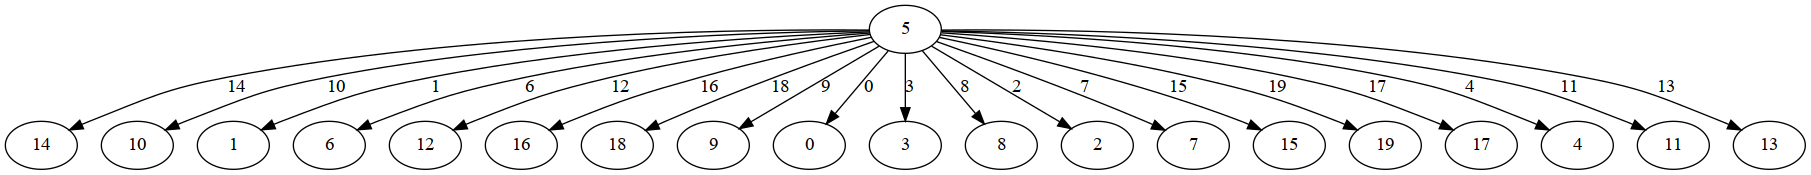

In [5]:
show_td_info(sampler)

Nevertheless, we can evaluate the cluster tree.

In this simple case, this will count the nucleotide sequences of length 20 (i.e. we expect to see a count of 4**20).

In [6]:
count = sampler.evaluate()
print("# =",int(count))

# = 1099511627776


Next, let's draw 10 samples. These samples encode uniformly drawn sequences of length 20. 

In [7]:
samples = [sampler.sample().values() for i in range(10)]
samples

[[0, 0, 0, 0, 2, 1, 0, 2, 2, 0, 3, 1, 1, 2, 0, 2, 0, 3, 3, 3],
 [3, 3, 1, 2, 1, 2, 3, 3, 3, 1, 0, 2, 1, 3, 3, 1, 1, 2, 3, 2],
 [3, 3, 1, 0, 2, 2, 1, 0, 0, 3, 2, 0, 2, 0, 2, 0, 1, 3, 3, 1],
 [0, 3, 2, 2, 3, 2, 0, 2, 1, 1, 1, 1, 1, 0, 2, 1, 3, 3, 3, 2],
 [0, 1, 2, 1, 3, 3, 2, 3, 3, 3, 2, 2, 3, 2, 1, 1, 0, 1, 3, 3],
 [0, 1, 0, 0, 0, 3, 2, 1, 3, 1, 2, 1, 3, 1, 1, 2, 3, 0, 3, 1],
 [3, 2, 0, 0, 0, 1, 3, 3, 2, 0, 2, 2, 0, 0, 3, 0, 0, 0, 2, 2],
 [3, 0, 1, 2, 0, 2, 3, 0, 3, 0, 3, 0, 0, 3, 0, 0, 3, 2, 0, 0],
 [2, 3, 3, 1, 3, 3, 2, 1, 3, 2, 1, 0, 0, 0, 3, 0, 2, 2, 1, 0],
 [2, 3, 3, 3, 2, 2, 0, 3, 3, 3, 3, 2, 1, 3, 0, 3, 2, 0, 3, 2]]

... and show them more pretty.

In [8]:
from infrared import rna
[rna.values_to_seq(s) for s in samples]

['AAAAGCAGGAUCCGAGAUUU',
 'UUCGCGUUUCAGCUUCCGUG',
 'UUCAGGCAAUGAGAGACUUC',
 'AUGGUGAGCCCCCAGCUUUG',
 'ACGCUUGUUUGGUGCCACUU',
 'ACAAAUGCUCGCUCCGUAUC',
 'UGAAACUUGAGGAAUAAAGG',
 'UACGAGUAUAUAAUAAUGAA',
 'GUUCUUGCUGCAAAUAGGCA',
 'GUUUGGAUUUUGCUAUGAUG']

## Adding complementarity constraints from an RNA secondary structure

We define a toy RNA secondary structure (in dot-bracket notation)

In [9]:
structure = "((((...))))(((...)))"

... and parse it.

In [10]:
bps = rna.parse(structure)
print(bps)

[(0, 10), (1, 9), (2, 8), (3, 7), (11, 19), (12, 18), (13, 17)]


Next, we define the class of complementarity constraints; we call it
BPComp for base pair complementarity. 
Each such constraint is constructed for two specific positions i and j. 
Then, the constraint is checked by testing whether the values x and y at the respective
positions i and j correspond to complementary base pairs. 

In [11]:
ir.def_constraint_class( 
    'BPComp',
    lambda i,j: [i,j],
    lambda x,y: rna.values_to_seq([x,y]) 
                  in ["AU","CG","GC","GU","UA","UG"]
)    

Btw, there is already a pre-defined constraint rna.BPComp,
which we could have used as well.

From the parsed structure, we generate a set of complementarity
constraints - one for each base pair.

In [12]:
cons = [ BPComp( i , j ) for (i,j) in bps ]

For illustrations, let's also print the variables of the constraints.

In [13]:
[c.vars() for c in cons]

[[0, 10], [1, 9], [2, 8], [3, 7], [11, 19], [12, 18], [13, 17]]

Now, we are ready to construct the new constraint model, including the
new constraints, and construct the corresponding sampler.

In [14]:
seqlen = len(structure) # --> number of positions / variables in the CN
model = ir.Model(seqlen,4)
model.add_constraints(cons)

sampler = ir.Sampler(model)

Let's first see whether the tree decomposition looks more interesting
this time.

tree width = 1
bags = [[19, 11], [9], [1, 9], [8], [8, 2], [10], [0, 10], [18], [12, 18], [13], [17, 13], [7], [3, 7], [5], [15], [4], [16], [14], [6], [19]]
edges = [(0, 1), (0, 3), (0, 5), (0, 7), (0, 9), (0, 11), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (1, 2), (3, 4), (5, 6), (7, 8), (9, 10), (11, 12), [19, 0]]


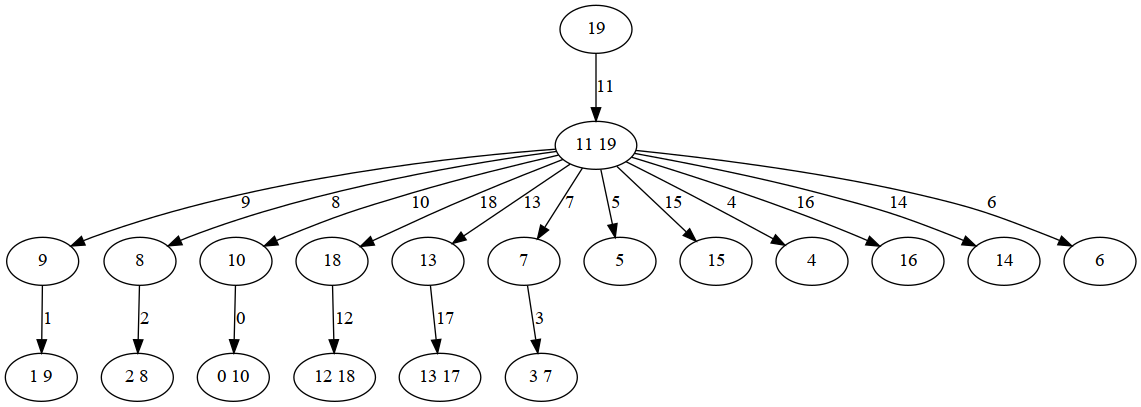

In [15]:
show_td_info(sampler)

As expected, the tree decomposition reflects the dependencies due to the new constraints. 

When we evaluate the model, we obtain the number of sequences that are
compatbile with our secondary structure (doing simple combinatorics, we
expect $6^7 * 6^4$).

In [16]:
count = sampler.evaluate()
print("# =",int(count))

# = 1146617856


It's time to generate samples again. Before this get's boring, we quickly
define a function to automatize this. For the fun of it, let's also draw sequence logos from the samples.

**Note**: logos will be drawn only if the modules `logomaker` and `matplotlib.pyplot` are properly installed.

In [17]:
def draw_logo(sequences):
    """Draw sequence logo for a set of sequences"""
    import logomaker as lm
    import matplotlib.pyplot as plt
        
    matrix = lm.alignment_to_matrix(sequences = sequences)
    logo = lm.Logo(matrix)
    logo.style_xticks(rotation=90, fmt='%d', anchor=0)
    logo.ax.xaxis.set_ticks_position('none')
    plt.savefig('test.svg')
    plt.show()

def opt_draw_logo(sequences):
    """Draw sequence logo, only if required modules are available""" 
    try:
        draw_logo(sequences)
    except ModuleNotFoundError:
        pass

def spit_them_samples_out(sampler,num,structure=None):
    """Generate and show samples"""
    samples = [ sampler.sample() for i in range(num) ]
    sequences =  [ rna.ass_to_seq(s) for s in samples ]
    if structure: print(structure)
    for s in sequences: print(s)
    opt_draw_logo(sequences)

Generate samples and print them with the given structure; we can see that the base pair constraints are satisfied by all samples.

((((...))))(((...)))
GUAUCAGAUGCCUCACGGGG
AUCAAGCUGGUACUUCCAGU
CAGAGCCUCUGGCUAGGGGU
GGGGCCGCUUCUAUGUGAUA
UAUGUACUAUGUGCUUUGUA
CGUCGACGACGUGUCGAGCG
CUGCCGUGCGGGUAUCCUAU
GAGCAGGGUUCCAGUUCCUG
GUAGUACUUACAGAACUUUU
CCGAAUUUCGGGUAACAUGC
UCUAUAGUGGGUAGGAACUG
GCGUAGGACGCGGUUACGCC
CUUUGGCGGGGCAUCCCGUG
UUGUGACACGACGCGAUGUG
UGGUCAGAUUGGAUUUGGUC
GGUGGUGUGUUGAGUUCUUC
CGGUUGCGUUGGCGAUUUGC
UUCUCCGAGGGUUCAGUGAA
GGUAAUGUGCUUGGGGAUUA
UCCACUUUGGGAGUUUAGCU


Matplotlib is building the font cache; this may take a moment.


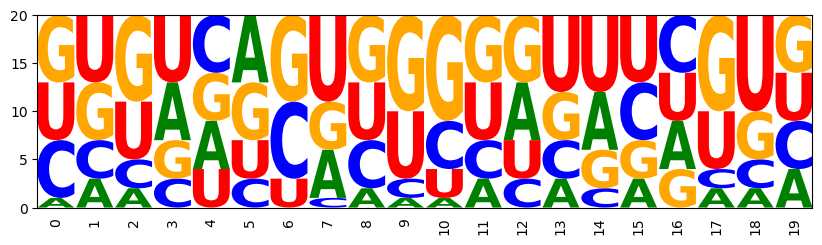

In [18]:
spit_them_samples_out(sampler,20,structure)

## Controlling the GC content

To control features of our samples like the GC content, we are going to
add suitable functions to our model. For the GC control, we define the
function class `GCCont`, which let us count the Gs and Cs in the
encoded sequence. For a specific position i, the function returns 1 if
the encoded nucleotide is G or C; otherwise, 0.

In [19]:
ir.def_function_class(
    'GCCont',
    lambda i: [i],
    lambda x: rna.value_to_nucleotide( x ) in "GC"
)

Btw, this function is as well pre-defined in Infrared's rna support module as
`rna.GCCont`.

GC-control is added to the sampler, simply by specifying the set of
functions (`gc_funs`), adding them to the sampler as a function group
`'gc'`, and setting the weight of the corresponding (automatically
generated) feature of the same name.

Note how the new functions can simply be added to the existing model with
base pair complementarity constraints. This provides a first good example of the
compositional construction of models in Infrared.

((((...))))(((...)))
UGGGAACUCUAAGUGUAAUU
CCUGCUCUGGGUGAUAUUUA
UACUCGAGGUGUGAUAAUCA
UAGGCCCCUUACGGCCUUCG
CUUUAUUAAAGAUAGCUUGU
UGUCUGAGGCGUGCAUUGCA
GGUCCGAGAUCCGCAUGGCG
GAGAGUGUUUUGCGGCUUGC
GCAAGAUUUGUAGACCGUCU
AACUACGAGUUUUAGUGUGA


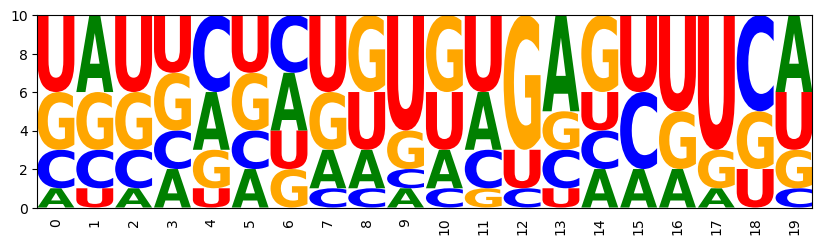

In [20]:
gc_weight = 0.12 # <- try different weights: -0.1, 0, 0.1, ...

# define set of GCCont functions
gc_funs = [ GCCont( i )
              for i in range( seqlen ) ]

# add functions as group 'gc' 
model.add_functions(gc_funs, 'gc')

# set the weight of the 'gc' feature
model.set_feature_weight(gc_weight, 'gc')

# construct sampler
sampler = ir.Sampler( model )

# generate samples
spit_them_samples_out( sampler, 10, structure )

## Controlling the BP energy

Next, we are going to introduce functions to compute the energy our secondary structure 
for the enoded sequence. To express energy in the base pair energy model, 
we are going to define a set of functions of the pre-defined type
`rna.BPEnergy`; one for each base pair.

In [21]:
bpe_funs = [ rna.BPEnergy( i, j, False ) for (i,j) in bps ] 

These functions are added to the existing model, as the GC functions
before. We put them into a new function group `'energy'`, which will
immediately allow us to control them (in addition to the GC content) through the
automatically generated feature `'energy'`.

In [22]:
model.add_functions(bpe_funs, 'energy')

Let's set weights of our two features and generate samples. By setting a negative weight for energy, we aim at low energy for the structure. The GC control allows us to counter-act the induced shift towards high GC content. For the latter purpose, we set a negative weight to aim at lower GC content.

((((...))))(((...)))
CGAGUUCCUCGAGGAUUCCU
CCCACGUUGGGAGUGAUACU
CUGGUUACUAGUUCGAUGAG
CAGUCUUGCUGGUCCCAGGC
AGGCAAUGCUUGCGAUUCGU
GGUUAUGAACUUGCUGAGCG
CGUGAUCCGCGGCCACCGGC
GCUCUUCGAGCUCCCCGGGA
UGCCAAGGGCAGUCUGUGGU
CGGCUCGGCUGGGGACACCC


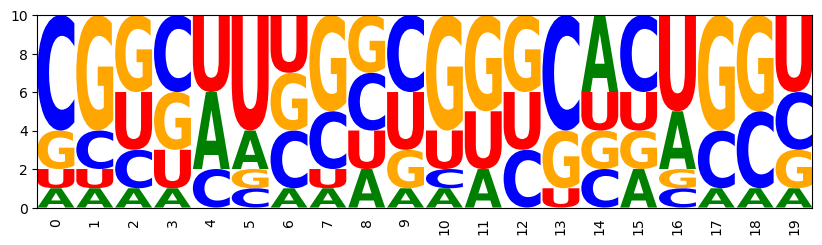

In [23]:
model.set_feature_weight(-0.5, 'gc')
model.set_feature_weight(-1, 'energy')

sampler = ir.Sampler(model)

spit_them_samples_out(sampler, 10, structure)

## Further constraints
We can even extend the model by further constraints, while maintaining the ability to control the features. As example of additional hard constraints, we are going to avoid GG dinucleotides.
Extending the model by such additional constraints, expectedly, goes through the steps of

* defining the new constraint type

* defining a set of constraints

* adding the set to the model

In [24]:
ir.def_constraint_class('AvoidGGConstraint',
                         lambda i: [i, i+1],
                         lambda x,y: rna.values_to_seq([x,y]) != "GG")

gg_cons = [ AvoidGGConstraint( i ) for i in range(seqlen-1) ]

model.add_constraints(gg_cons)

Finally, we construct the sampler for the extended model and generate samples.

((((...))))(((...)))
AGCGUGUCGUUAGCGAAGCU
AGUUAAAAGCUUAUGCCAUA
CGACUAUGUCGUGAAUAUCA
GAAAAGAUUUUUUGUCCCAA
CAAUAUAAUUGUGUUUUACG
UUAGAAUCUAGUAAUACUUA
GUCGUGCCGACUAAUCGUUA
GAGACAAUCUCGAUGAUGUU
UGAGCACUUCAGUGAAUCAC
UACUCCCAGUGCGAAUGUCG


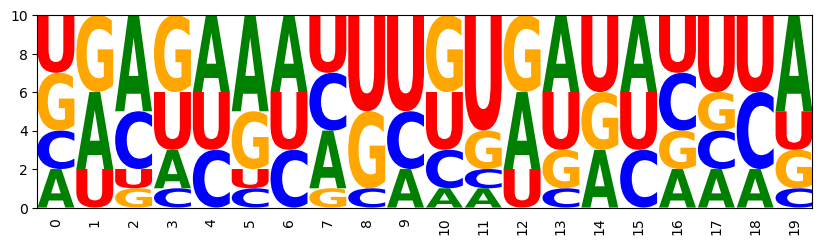

In [25]:
sampler = ir.Sampler(model)

spit_them_samples_out(sampler, 10, structure)

## Targeting specific GC content and energy

The previous model allowed to control the mean GC content and base pair energy of the produced model by manually tweaking the weights.

This leaves several challenges if we would want to produce samples with defined GC content and energy:

* we would have to filter the generated samples for a specific tolerance range around the targeted values

* the features are not independent, thus changing one weight requires changing the other - this would get even harder for more than two features.

Infrared supports these goals in a general way by implementing a multi-dimensional Boltzmann sampling strategy.

For this purpose, first set up the model and sampler as before.

In [26]:
model =  ir.Model(seqlen, 4)
model.add_constraints(cons)
model.add_functions(bpe_funs, 'energy')
model.add_functions(gc_funs, 'gc')

sampler = ir.Sampler( model )

Infrared now allows to set target values and tolerances for all (or selected) features and then produce targeted samples using the method `Sampler.targeted_sample()`.

In the code below, we print samples with their energy and GC-content. Note how we obtain these values simply by asking the model to evaluate the features for the sample.

CCGUACAGCGGUCGUAACGA -11.92 12.00
GGGGCUUCUCCCGGAUUUUG -11.06 12.00
GGCGCAACGCCAGAUUGUCU -11.56 12.00
UGGGAUUCUCGGGGAAGUCC -11.06 12.00
CGCCUCAGGCGGGUAAUGUU -11.06 12.00
CCCCUUCGGGGAACAUAGUU -11.56 11.00
GUUCAAGGGGCGGUAUUGCC -11.06 12.00
UUGCAAAGUGGGGGACACCC -11.06 12.00
UUGCACAGCGACGCAAAGCG -11.92 12.00
CUGCGUUGUGGUGGAUUCCG -11.06 12.00


GGAUAAAAUCCCCCAAUGGG -11.56 10.00
CCUAUAUUAGGCCGCAACGG -11.56 11.00
UCCCAAUGGGAACGACUCGU -11.56 11.00
UUGGCUUCCAGGCCAAUGGC -11.92 12.00
CGUGAAUCACGGGUUGUACC -11.56 11.00
AGGUGUAACCUGCGUUGCGC -11.56 12.00
GUGGUUACCACCACGCUGUG -11.56 12.00
AGCGAAGCGUUCGGAUUCCG -11.92 12.00
CUCUUCUGGGGGGGUUACCU -11.06 12.00
GAGAAUCUCUCGGGAAACCC -11.56 11.00


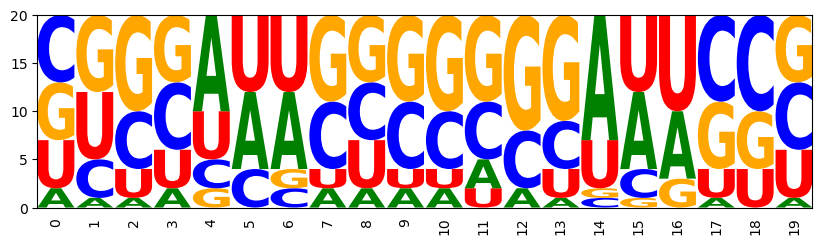

In [27]:
sampler.set_target( -12, 1, 'energy' )
sampler.set_target( 10, 2, 'gc' )

samples = list()
for i in range(20):
    sample = sampler.targeted_sample()
    sequence = rna.ass_to_seq(sample)
    print("{} {:.2f} {:.2f}".format(sequence, 
                                    model.eval_feature(sample,'energy'),
                                    model.eval_feature(sample,'gc')))
    samples.append(sequence)
opt_draw_logo(samples)

## Targeting Turner energy

Finally, for real applications, it is typically much more relevant to target specific Turner energy than specific energy in the simple base pair model.
In Infrared, we solve this by defining and adding a new feature `'Energy'` to the model that calculates Turner energy (by calling a function of the Vienna RNA package). In addition to defining this calculation, we specify as well that the new feature should control the function group `energy`. In this way, Infrared will use base pair energy as proxy of Turner energy.

**Note:** this requires the Vienna RNA package with working Python bindings (currently, this fails in Windows even after installing the package from binaries)

In [28]:
import RNA

model.add_feature( 'Energy', # feature name
                   'energy', # controlled group(s)
                   #
                   # function to evaluate the feature for a sample;
                   # NOTE how we have to bind i
                   lambda sample, structure=structure:
                      RNA.energy_of_struct( rna.ass_to_seq( sample ),
                                            structure )
                 )

As before, we set targets and generate samples. Of course, this time, we set a target range for the new feature of Turner energy.

CCGCUAAGCGGACCUUAGGU -13.14 -4.80 12.00
GGUGAUCCACCGGACAAUCC -11.56 -4.00 12.00


GUCUGAUGGACGGCUAUGCC -11.92 -4.10 12.00
GACUUAUGGUCGCCUUGGGC -11.92 -4.10 12.00
GGCCUUUGGCCGACCUUGUU -11.92 -4.20 12.00
CCCAGAUUGGGGGCUAAGCU -11.92 -4.10 12.00


GGCAUUUUGCCGCCAUGGGU -11.92 -4.80 12.00
GGCUUUCAGCCGCUAAAGGC -11.92 -4.50 12.00
GAGGUCUCCUCAGCUAUGCU -11.56 -4.00 11.00
CCCCAUUGGGGGGAAAAUCC -13.14 -5.60 12.00
CCCCUAUGGGGCACAAAGUG -13.14 -4.00 12.00
UGCCAAUGGCACGCUAUGCG -13.14 -4.30 12.00


GCCCGUUGGGCGGAAAAUCU -11.92 -4.70 12.00
GCGGUAACCGCACCAAAGGU -13.14 -5.30 12.00
GGGUAGAACCCAGCCAUGCU -11.56 -4.50 12.00
CCCGUAACGGGGCUUAUAGC -13.14 -4.50 12.00
GUCAAAAUGACGCCACGGGC -11.56 -4.10 12.00
GGUGUAUCACCGGCAUAGCC -13.14 -5.50 12.00
GGGCCUCGCCCGUAUAAUAC -11.56 -4.20 12.00
CCAGUUUCUGGGCCAAAGGC -13.14 -4.70 12.00


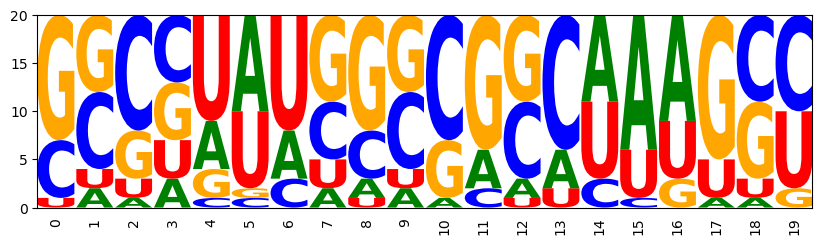

In [29]:
sampler = ir.Sampler(model)

sampler.set_target( -5, 1, 'Energy' )
sampler.set_target( 10, 2, 'gc' )

samples = list()
for i in range(20):
    sample = sampler.targeted_sample()
    print("{} {:5.2f} {:5.2f} {:5.2f}".format(rna.ass_to_seq(sample), 
                                    model.eval_feature(sample,'energy'),
                                    model.eval_feature(sample,'Energy'),
                                    model.eval_feature(sample,'gc')))
    samples.append(rna.ass_to_seq(sample))

opt_draw_logo(samples)

## Add IUPAC constraints

In many design applications, we have prior knowledge on the sequences, which can be encoded as IUPAC string. 
Below, we generate constraints from a IUPAC string and add them to the Infrared model for targeting Turner energy and GC content.

GGGCUUUGCCCCAGUAACUG
GGCCUAAGGCCCACUUAGUG


GGGCUUAGCCCCGAAUAUCG


GGGGUAACCCCCACUAAGUG
GCCCUAUGGGCCACAUAGUG
GCCCUAAGGGCCGUAUAACG
GGGCUUUGCCCCGUAUAACG
GGCCUAAGGCCCGUAUAACG


GCCCUUAGGGCCAGUAACUG
GGGGUAUCCCCCGAAAAUCG
GCCCUAUGGGCCGUUUAACG
GGGCUUUGCCCCGAAUAUCG
GGGGUAUCCCCCGAAUAUCG
GGGCUUAGCCCCGAAUAUCG
GGGGUAACCCCCGAAAAUCG
GGGGUUUCCCCCAGAAACUG


GGCCUAUGGCCCACUAAGUG


GGGCUAUGCCCCGAUAAUCG
GGGCUUUGCCCCACAAAGUG
GCCCUUUGGGCCGAAUAUCG


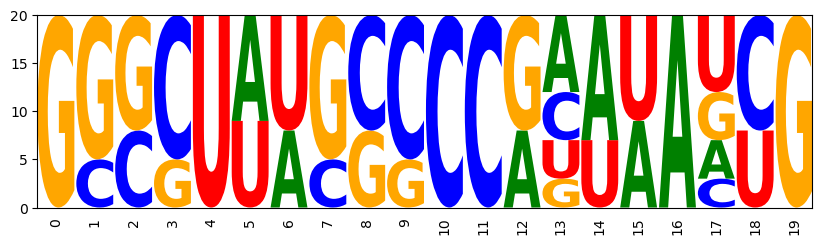

In [30]:
sequence = "RSSSUWWSSNNSNNNNMNYR"

for i,x in enumerate(sequence):
    model.add_constraints(ir.ValueIn(i,rna.iupacvalues(x)))

sampler = ir.Sampler(model)

sampler.set_target( -5, 1, 'Energy' )
sampler.set_target( 10, 2, 'gc' )

samples = list()
for i in range(20):
    sample = rna.ass_to_seq(sampler.targeted_sample())
    print(sample)
    samples.append(sample)
    
opt_draw_logo(samples)

**Remark:** At this point, we have implemented the full functionality of the RNA design approach IncaRNAtion (Reinharz et al., Bioinformatics 2013) in Infrared. In Infrared, we can easily extend the model further by including further constraints and going on to multi-target design. Infrared makes the latter, which extends functionality to the tool RNARedPrint (Hammer et al; BMC Bioinf 2021), look surprisingly simple. (We demonstrate this in a separate accompanying notebook, as well as in the Infrared-based application RNARedPrint 2).